## Sentiment Analysis

[Previously](https://dadaromeo.github.io/the-voice-tweets-mining-part-4), we explore *topic modeling* an algorithm used to discover what users are talking about. But often, its not important to know what users are saying, but how they are saying it. [*Sentiment analysis*](https://en.wikipedia.org/wiki/Sentiment_analysis) seeks to automatically associate a piece of text with a *sentiment score*, a positive or negative emotional score. Aggregating sentiment can give an idea of how people are responding to an event or a topic.

The way this task is usually done is by using [*Supervised learning*](https://en.wikipedia.org/wiki/Supervised_learning) principles. First, we find a *lexicon*, a dictionary of sentences (tweets in this context) and thier *positive*, *neutral* or *negative* labels. We then use a [training algorithm](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to learn the words - polarity association. It means the algorithm learns what words or features are associated with which labels. Finally, we pass to the algorithm our own (useen) tweets and it judges whether the text in the is positive or negative based on the likelihood for each possibility.

For this to work properly, we need to be carefull about the source of the lexicon we're choosing. Words having different meaning in diffrent contexts. In this post, we don't have a lexicon nor want to build one. We will rely instead on the concept of *mutual information* to detect the polarity of the tweet.

### Pointwise mutual information

[Pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) (PMI) is a measure of association between two events. The PMI of a pair of outcomes $x$ and $y$ to discrete random variables $X$ and $Y$ quantifies the discrepancy between the probability of their coincidence given their joint distribution and their individual distributions, assuming independence an is given by:

$$pmi(x;y) = \log{\frac{p(x,y)}{p(x)p(y)}}$$

where $p(x)$ and $p(y)$ are the marginals and $p(x,y)$ is the joint distribution.

The idea behind this choice is to use a set set or an anchor (a word that carry strong polarity) of positve and negative words (we could derive them from tweets) and for each word int the tweet, we measure thier coccurences (with PMI) with these words.

In this post, we will use a slight variant of PMI, th Normalized pointwise mutual information (NPMI) given by:

$$npmi(x,y) = \frac{pmi(x,y)}{h(x,y)}$$

where $h(x,y) = -\log p(x,y)$

In [2]:
import re
import string
from datetime import datetime

import numpy as np
import pandas as pd
import emoji
import altair
from pymongo import MongoClient
from twitter.parse_tweet import Emoticons
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder

np.random.seed(42)

In [3]:
host = "localhost"
port = 27017

db = MongoClient(host, port).search

In [4]:
cols = ["created_at", "tweet"]
tweets = pd.DataFrame(columns=cols)

for tweet in db.thevoice.find():
    if not("retweeted_status" in tweet.keys()):
        data = dict(zip(cols,[tweet["created_at"], tweet["text"]]))
        tweets = tweets.append(pd.DataFrame(data, index=[0]), ignore_index=True)

Since the `created_at` field was store as a string during [data collection](https://dadaromeo.github.io/the-voice-afrique-tweets-mining-part-1), we use the `strptime` helper to restore the values in this field to a valid Python's `datetime` object.

In [5]:
def strptime(ts):
    cformat = "%a %b %d %H:%M:%S %Y"
    uformat = "%a %b %d %H:%M:%S %z %Y"
    
    ctime = datetime.strptime(ts, uformat).ctime()
    return datetime.strptime(ctime, cformat)

In [6]:
tweets = tweets.assign(created=tweets.created_at.apply(strptime))
tweets = tweets.drop("created_at", axis=1)

We build a set of stop words, words that wil be discard during the preprocessing of the raw tweet.

In [7]:
stop_tokens = set()
stop_tokens.update(list(string.punctuation))
stop_tokens.update(stopwords.words("french"))
stop_tokens.update(Emoticons.POSITIVE)
stop_tokens.update(Emoticons.NEGATIVE)
stop_tokens.update(["’", "…", "ca", "°", "çà", "»", "«", "•", "the",
                    "voice", "afrique", "voix", "–", "::", "“", "₩", "🤣"])

with open("data/stopwords-fr.txt") as f:
    stop_tokens.update(map(str.strip, f.readlines()))

The `parse` function in this post is slightly different from the one used in the [topic modeling](https://dadaromeo.github.io/the-voice-tweets-mining-part-3) post. It doesn't discard the emojis icons since they are carry a strong polarity meaning. In fact, we use this 😍 as a positive anchor in our PMI calculation. For the negative anchor, we  use this one 😂 because in this particular dataset, we found it most associated with sacasm. And everyone knows that sacasm is a sharp form of humor, intended to muck or hurt.

We follow the presentation in this [paper](https://arxiv.org/abs/cs/0212032) and define the *Semantic Orientation* (SO) of a tweet as:

$$so(tweet) = \sum_{w \in tweet} npmi(w, 😍) - \sum_{w \in tweet} npmi(w, 😂)$$

See the `orientation` function.

In [8]:
tokenize = TweetTokenizer().tokenize

def parse(text):
    
    text = text.strip()
    text = text.strip("...")
    text = " ".join(re.split(r"\w*\d+\w*", text)).strip()
    tokens = tokenize(text)
    
    for token in tokens:
        cond = (token.startswith(("#", "@", "http", "www")) or
                "." in token or
                "'" in token
                )
                
        if not(cond):
            yield token

def preprocess(text):
    text = text.lower()
    for token in parse(text):
        if not(token in stop_tokens):
            yield token

We add `1` to the numerator and `2` in the denomination of the calculation of marginal and joint probabilities. It's a simple heuristic to avoid potential numerical instabilities when estimating the probability of a event as a frequency.

The `BigramCollocationFinder` helps us build the words and bigram coccurences frequency dictionnairies that will be used later in the calculation of marginals and joints.

In [9]:
bigram = BigramCollocationFinder.from_documents(map(preprocess, tweets.tweet.tolist()))

muck = "😂"
happy = "😍"

n_words = len(bigram.word_fd)
n_bigrams = len(bigram.ngram_fd)

def marginal_p(w):
    """Marginal probabilty"""
    
    freq = bigram.word_fd.get(w, 0) + 1
    return freq / (n_words + 2)

def joint_p(w, z):
    """Joint probability"""
    freq = bigram.ngram_fd.get((w,z), 0) + 1
    return freq / (n_bigrams + 2)

def pmi(w, z):
    """Pointwise mutual information"""
    
    return np.log(joint_p(w,z) / (marginal_p(w) * marginal_p(z)))

def npmi(w, z):
    "Normalized pointwise mutual information"
    
    return pmi(w,z) / -np.log(joint_p(w,z))

def polarity(score):
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"

def orientation(text):
    """Semantic orientation"""
    
    ps = np.sum([npmi(token, happy) for token in preprocess(text)])
    ns = np.sum([npmi(token, muck) for token in preprocess(text)])
    
    return ps-ns

def extract(df, names):
    """This function walks trought the dataframe,
    extract tweets related to each coach and concatenate
    the into a common dataframe.
    """
    from functools import partial
    
    def word_in_text(word, text):
        if word in preprocess(text):
            return True
        else:
            return False
    
    field = "name"
    new_df = pd.DataFrame(columns=list(df.columns)+[field])
    
    for name in names:
        ifelse = partial(word_in_text, name)
        mention = df[df.tweet.apply(ifelse)].copy()
        mention[field] = name.title()
        new_df = new_df.append(mention, ignore_index=True)
    
    return new_df

In [10]:
tweets["count"] = 1
tweets = tweets.assign(orientation=tweets.tweet.apply(orientation))
tweets = tweets.assign(polarity=tweets.orientation.apply(polarity))

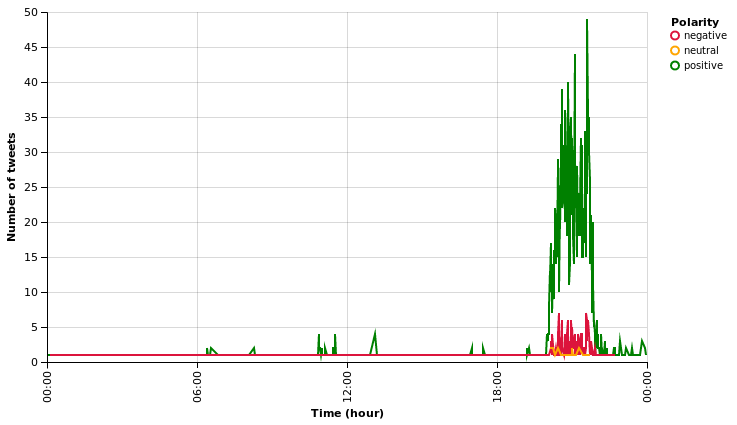

In [11]:
altair.Chart(tweets).mark_line().encode(
    x=altair.X("created", timeUnit="hoursminutes",
               scale=altair.Scale(nice="hour"),
               axis=altair.Axis(title="Time (hour)"),
              ),
    y=altair.Y("count", aggregate="sum",
               axis=altair.Axis(title="Number of tweets"),
              ),
    color=altair.Color("polarity", legend=altair.Legend(title="Polarity"),
                       scale=altair.Scale(range=["crimson", "orange", "green"])),
).configure_cell(
    width=600,
)

With this figure, we see that the overall sentiment is positive. The neutral being the less common, which the expected behaviour from the users/viewers (to or not to be) for this kind of event (I guess).

We dig into the tweets and extract (with the `extract` function) those related to each coach and plot them.

In [12]:
names = ["asalfo", "charlotte", "lokua", "singuila"]
coaches = extract(tweets, names)

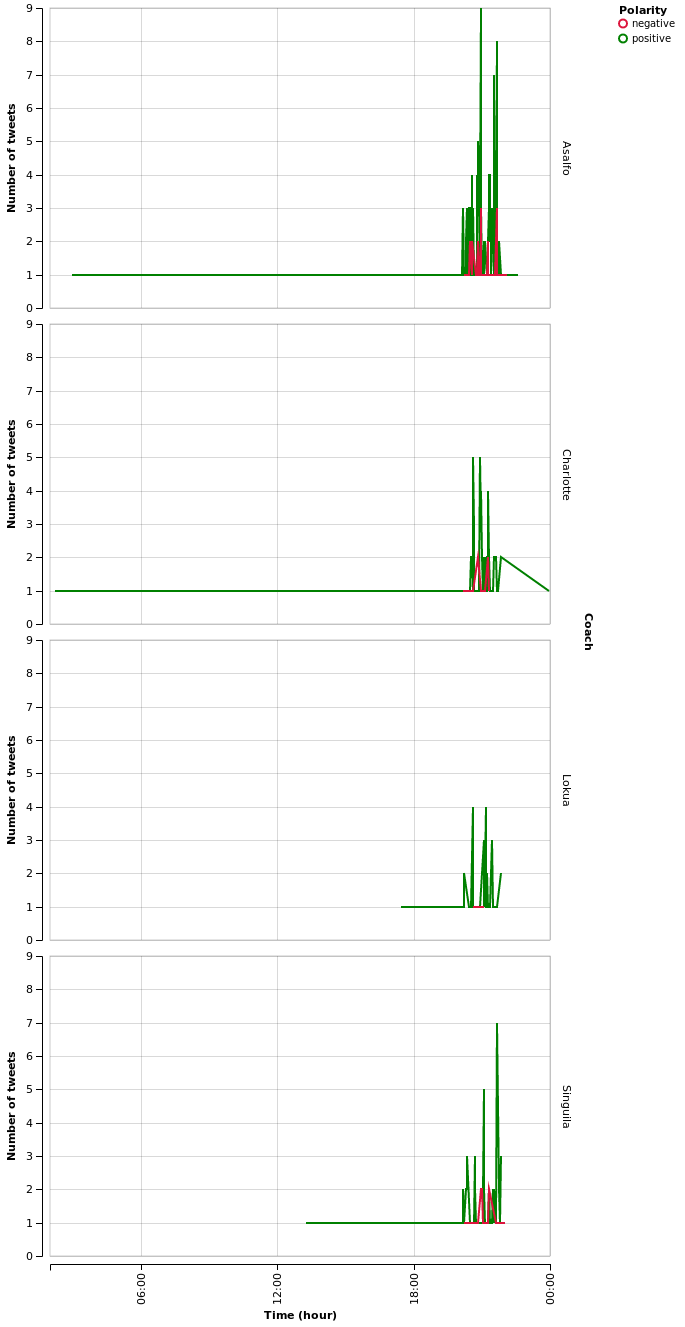

In [13]:
altair.Chart(coaches).mark_line().encode(
    x=altair.X("created", timeUnit="hoursminutes",
               scale=altair.Scale(nice="hour"),
               axis=altair.Axis(title="Time (hour)"),
              ),
    y=altair.Y("count", aggregate="sum",
               axis=altair.Axis(title="Number of tweets"),
              ),
    row=altair.Row("name", axis=altair.Axis(title="Coach")),
    color=altair.Color("polarity", legend=altair.Legend(title="Polarity"),
                       scale=altair.Scale(range=["crimson", "green", "orange"])),
).configure_cell(
    height=300,
)

We do the same with some candidates.

In [14]:
names = ["nadia", "eds", "verushka", "brake"]
candidates = extract(tweets, names)

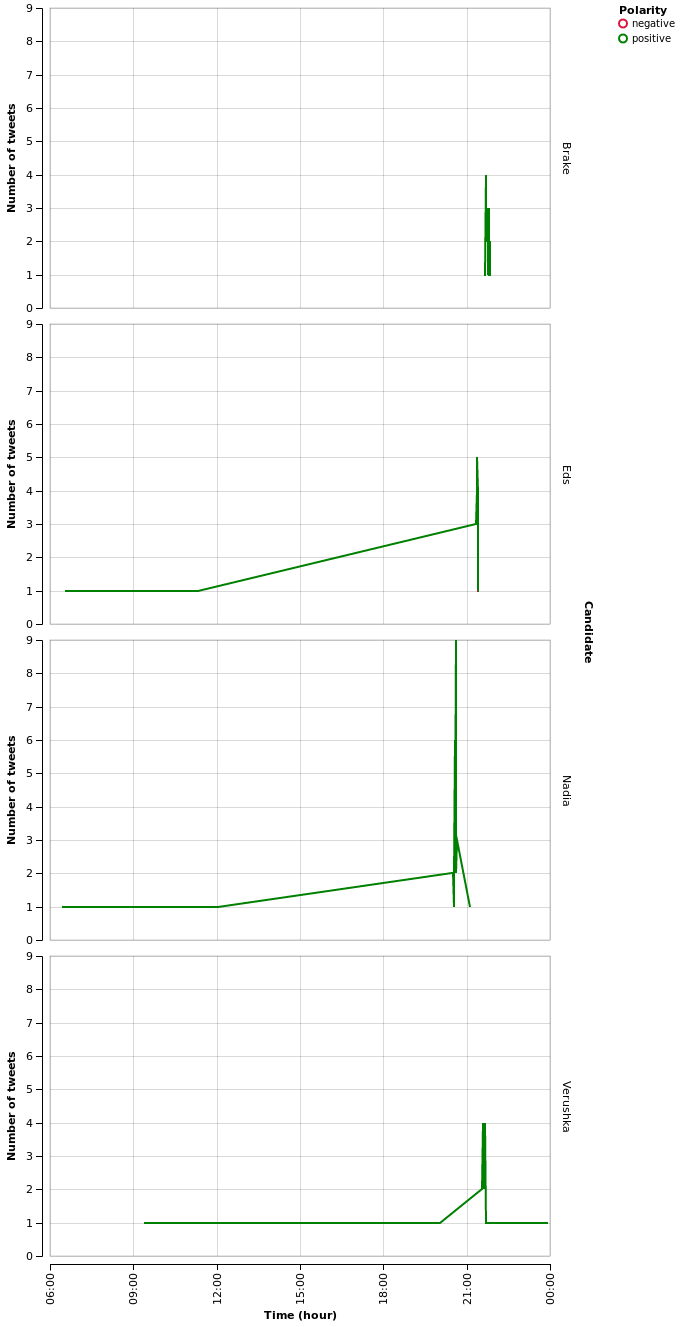

In [15]:
altair.Chart(candidates).mark_line().encode(
    x=altair.X("created", timeUnit="hoursminutes",
               scale=altair.Scale(nice="hour"),
               axis=altair.Axis(title="Time (hour)"),
              ),
    y=altair.Y("count", aggregate="sum",
               axis=altair.Axis(title="Number of tweets"),
              ),
    row=altair.Row("name", axis=altair.Axis(title="Candidate")),
    color=altair.Color("polarity", legend=altair.Legend(title="Polarity"),
                       scale=altair.Scale(range=["crimson", "green", "orange"])),
).configure_cell(
    height=300,
)

With the `show_tweets` function below, we print `n` randomly choosen tweets associated with *negative* or *positive* sentiment for a paticular coach. This viusal inspection will help us see if our method did a god job by classify all the tweets proprely or a least, most of them.

In [16]:
def show_tweets(name, df, n=5, kind="negative"):
    
    def print_header(name, kind, n):
        
        title = "{} randomly choosen tweets marked with '{}' sentiment for {}".format(n, kind, name)
        print(title)
        print("".join(["-"]*100))
        print()
    
    select = df[(df.name == name) & (df.polarity == kind)]
    
    if len(select) > 0:
        size = min(n, len(select))
        ids = np.arange(len(select))
        idx = np.random.choice(ids, size=size, replace=False)
        print_header(name, kind, size)
        for i,tweet in enumerate(select.tweet.iloc[idx]):
            print("{} - {}".format(i+1, tweet))
    else:
        print("Nothing found!")

#### Negative sentiment

We print tweets marked with 'negative' sentiment for:

- Asalfo
- Charlotte
- Lokua
- Singuila

In [17]:
show_tweets("Asalfo", coaches)

5 randomly choosen tweets marked with 'negative' sentiment for Asalfo
----------------------------------------------------------------------------------------------------

1 - Asalfo il monte il descend avec la voix du gars 😂😂😂😂 #TheVoiceAfrique
2 - Asalfo commence par du "fake" : Ma cherie tu es merveilleuse ce soir.! 😂😂😂😂 #LagoDeJohnny #TheVoiceAfrique
3 - " Si tu te retournes avec Charlotte, tu vas gagner quoi devant Elle ?" Lance Asalfo à Singuila #TheVoiceAfrique 😂😂😂😂
4 - Asalfo quand il prend la parole avec sa voix la 😂😂😂😂😂 #TheVoiceAfrique
5 - "Tu es parfaite à  100%" 😕😕😕😕😂😂😂😂😂 #TheVoiceAfrique eseh Asalfo


In [18]:
show_tweets("Charlotte", coaches)

5 randomly choosen tweets marked with 'negative' sentiment for Charlotte
----------------------------------------------------------------------------------------------------

1 - Papa dit Charlotte dipanda se maquille on dirais masque gouro eeeh 😂😂😂😂
#TheVoiceAfrique
2 - Charlotte Dipanda dit qu elle aime la coiff de la fille... hmmm je comprends le reste.... #MieuxJemeTais #TheVoiceAfrique 😂😂😂😂
3 - Charlotte Dipanda ne peut pas mordre la main qui lui a donné à manger 😂😂😂 #TheVoiceAfrique
4 - "Si tu te retournes après Charlotte  tu vas gagner quoi..??"
Ouaarr Asalfo😂😂😂
#TheVoiceAfriqueFrancophone
5 - Aie c booo, Coucou de Charlotte. Bravo mami... Juska elle oublie son age 😂
#TheVoiceAfriqueFrancophone


In [19]:
show_tweets("Lokua", coaches)

2 randomly choosen tweets marked with 'negative' sentiment for Lokua
----------------------------------------------------------------------------------------------------

1 - POUAHHHH le vent de Lokua 😭😂😂#TheVoiceAfrique
2 - Pourquoi il n'y a que Lokua qui ne s'agite pas trop .😂😂 #TheVoiceAfrique


In [20]:
show_tweets("Singuila", coaches)

5 randomly choosen tweets marked with 'negative' sentiment for Singuila
----------------------------------------------------------------------------------------------------

1 - Mdrrr Singuila c'est mon coach préféré, un barasseur de première catégorie, il se retourne pour les gos seulement 😂 #TheVoiceAfrique
2 - Le regard de Singuila quand il s'est tourné et la vu putain😂😂😂😂😂😂😂 #TheVoiceAfrique
3 - " Si tu te retournes avec Charlotte, tu vas gagner quoi devant Elle ?" Lance Asalfo à Singuila #TheVoiceAfrique 😂😂😂😂
4 - Singuila tout son anglais la c'est ''hello '' ou bien ?  Depuis la hello,  hello 😂😂😂 #TheVoiceAfrique
5 - Hum A'salfo.. Toujours a attendre que Singuila veuille buzzer pour aussi le faire 😂😂😂😂
#TheVoiceAfrique


#### Positive sentiment

We print tweets marked with 'positive' sentiment for:

- Asalfo
- Charlotte
- Lokua
- Singuila

In [21]:
show_tweets("Asalfo", coaches, kind="positive")

5 randomly choosen tweets marked with 'positive' sentiment for Asalfo
----------------------------------------------------------------------------------------------------

1 - asalfo il a quel soucis mm mdr #TheVoiceAfrique
2 - Tu l'a faite 😹😹😹😹😹 Asalfo m'a tué 🚼🚼 #Thevoiceafrique
3 - Asalfo même hein..Tu appuies ou pas. .On dirait qu'il attend que les autres buzzent. ..#TheVoiceAfrique
4 - Asalfo je sait pas ce qu'il fait la  #TheVoiceAfrique
5 - Ptdrrrrrr Asalfo a sauvé la fille la sinon le village allait être déçu #TheVoiceAfrique


In [22]:
show_tweets("Charlotte", coaches, kind="positive")

5 randomly choosen tweets marked with 'positive' sentiment for Charlotte
----------------------------------------------------------------------------------------------------

1 - C'est asalfo qui a raison même. Si tu te retourne singuila tu vas gagner quoi devant charlotte 😅😅 #TheVoiceAfrique
2 - La séquence émotion : La tata camerounaise de 53 ans qui a accueilli Charlotte Dipanda dans ses débuts. #TheVoiceAfrique
3 - Owww j'adore cette chanson de charlotte #TheVoiceAfrique
4 - De l'émotion pure sur un coucou de Charlotte. Magnifique! #TheVoiceAfrique
5 - Charlotte des qu'on te choisit tu redeviens CAMER #TheVoiceAfrique


In [23]:
show_tweets("Lokua", coaches, kind="positive")

5 randomly choosen tweets marked with 'positive' sentiment for Lokua
----------------------------------------------------------------------------------------------------

1 - @thevoiceafrique ohhhhh spoiler hahahaha.  Bienvenue dans la #TeamLokua brave fille !! T'es à ta place avec le grand Lokua
2 - Lokua n'est pas notre camarade #TheVoiceAfrique
3 - Jui sure quel va take lokua! #TheVoiceAfrique
4 - Lokua trop de charisme pas besoin de se concerter avec les autres pour se retourner 👌🏼 #TheVoiceAfrique
5 - Non mais Brake respect l'espace personnel quand même laisse Lokua tranquille!!! #TheVoiceAfrique https://t.co/ycPvRukcc5


In [24]:
show_tweets("Singuila", coaches, kind="positive")

5 randomly choosen tweets marked with 'positive' sentiment for Singuila
----------------------------------------------------------------------------------------------------

1 - Singuila êt Charlotte... Erhhmmmmm 

#TheVoiceAfrique
2 - Mdrrr Shayden est aller pour faire câlin à Singuila ? J'espère qu'il va bien la faire travailler. #TheVoiceAfrique
3 - Singuila a des bêtes vocales dans sa team innnh oulaaa #TheVoiceAfrique
4 - C'est asalfo qui a raison même. Si tu te retourne singuila tu vas gagner quoi devant charlotte 😅😅 #TheVoiceAfrique
5 - personne ne buzze????? serieux?    ahh merci Singuila!!!! #TheVoiceAfrique


It looks like our SO method did a relatively god job. We can see that by reading the ouputed tweets.

### Related posts

- [Mining Twitter Data with Python (Part 6 – Sentiment Analysis Basics)](https://marcobonzanini.com/2015/05/17/mining-twitter-data-with-python-part-6-sentiment-analysis-basics/)

- [Twitter sentiment analysis with R](http://analyzecore.com/2014/04/28/twitter-sentiment-analysis/)

## Conclusion

This is the last post in our post series and there are lot of dimensions we haven't explored. A tweet carries a lot of informations that can be mined to spot interesting things. On on these is the spatial dimension. We could plot the tweets or users location to see where the viewers are most active. We can combine this information with topic modeling or the sentiement analysis we performed on this plot to see the geodistribution of sentiments or topics across locations.

Before closing, we want to say tha the data we analysed in these posts are just a snapshot of what viewers are saying about the event. The Voice Afrique Francophone certainly has millions of viewers and most of them are not on Twitter or not connected at all. Even those who are connected to Twitter may not have left a single message during about the event. May be they don't have the opportunity or the time during the show.

We're really happy that you follow up to this point. If you just reach this page, you can look [here](https://dadaromeo.github.io/the-voice-afrique-tweets-mining-part-1) to start.

Thanks for reading, comments are welcome.